In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv("./data/train.csv")
test_data = pd.read_csv("./data/test.csv")

y = train_data.pop("price")

n_train = len(train_data)
all_data = pd.concat((train_data, test_data), axis=0)

In [3]:
all_data.head()

,id,carat,cut,color,clarity,depth,table,x,y,z
0,0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55
1,1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05
2,2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50
3,3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71
4,4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77


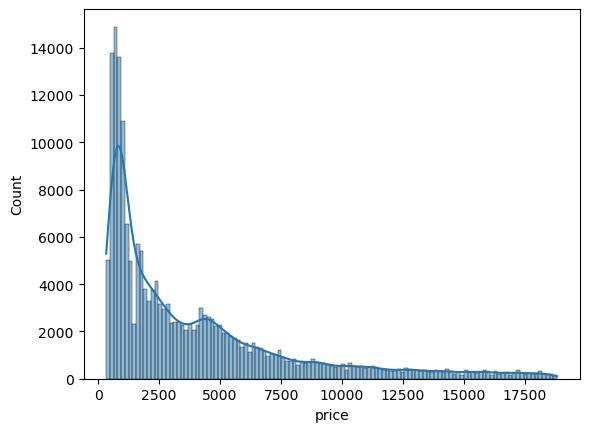

In [4]:
ax = sns.histplot(y, kde=True)

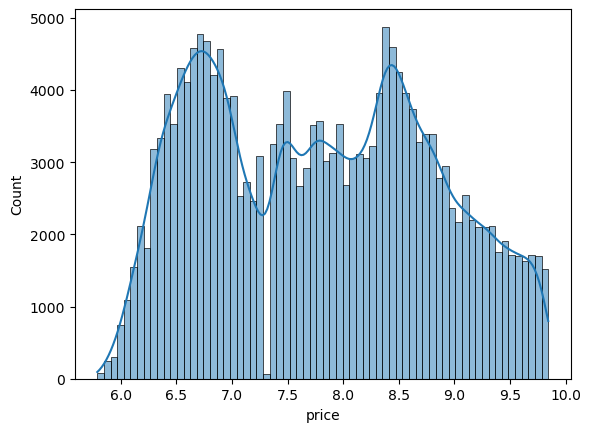

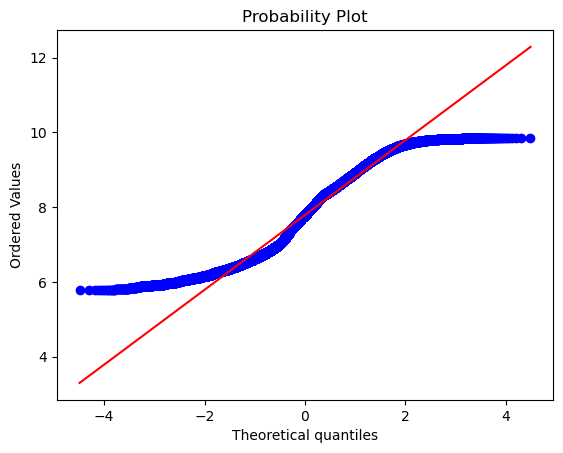

In [5]:
from scipy import stats

y_log = np.log1p(y)
sns.histplot(y_log, kde=True)
plt.show()
ax = stats.probplot(y_log, plot=plt)
plt.show()

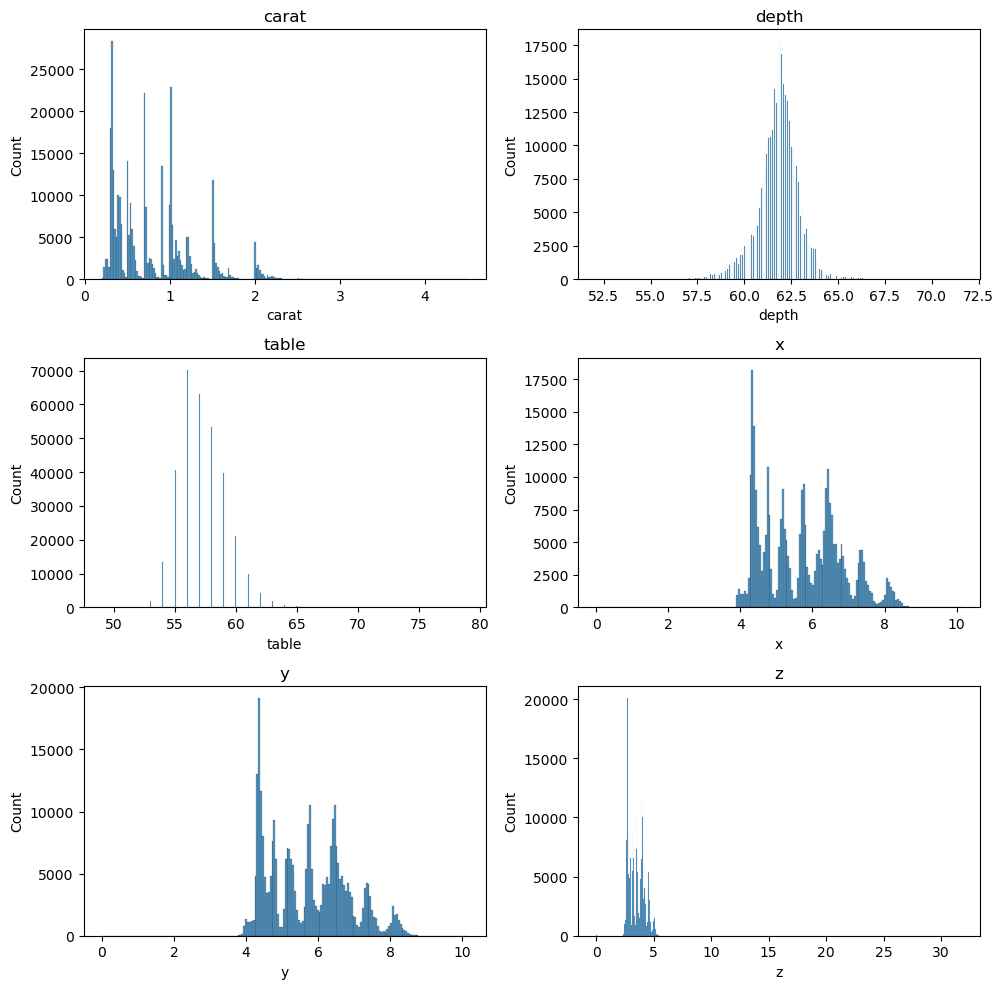

In [6]:
numeric_columns = all_data.select_dtypes(include=[np.number]).columns.drop("id")
n_cols = int(np.ceil(len(numeric_columns) / 3))

fig, ax = plt.subplots(nrows=3, ncols=n_cols, figsize=(10, 10), squeeze=False)
for i, col_name in enumerate(numeric_columns):
    row = i // n_cols
    col = i % n_cols
    sns.histplot(all_data[col_name], kde=False, ax=ax[row][col])
    ax[row][col].set_title(col_name)
plt.tight_layout()
plt.show()

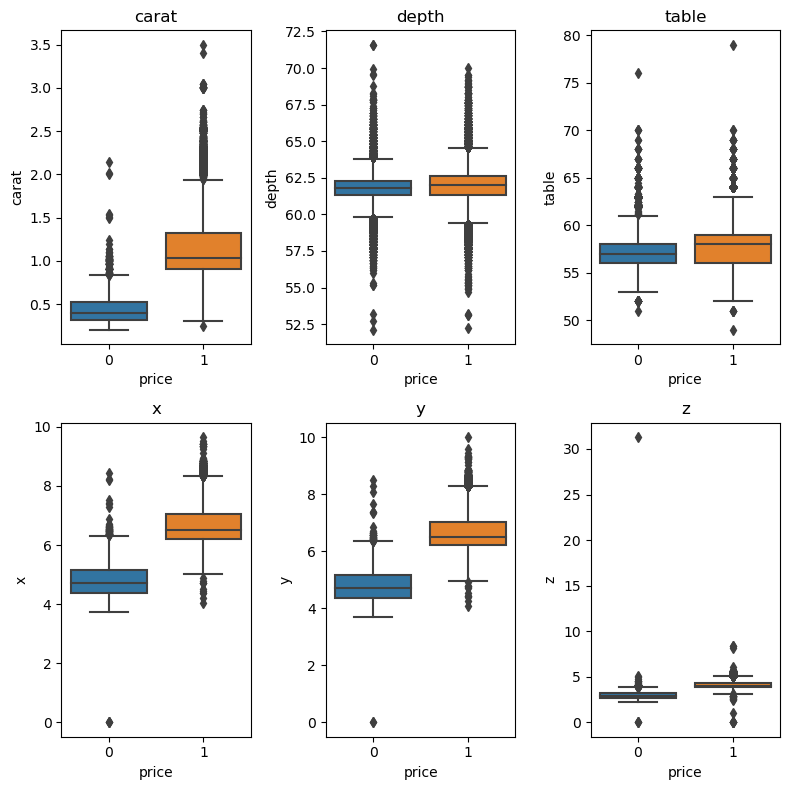

In [7]:
numeric_columns = all_data.select_dtypes(include=[np.number]).columns.drop("id")
n_cols = int(np.ceil(len(numeric_columns) / 2))

fig, ax = plt.subplots(nrows=2, ncols=n_cols, figsize=(8, 8), squeeze=False)
for i, col_name in enumerate(numeric_columns):
    row = i // n_cols
    col = i % n_cols
    sns.boxplot(
        y=train_data[col_name], x=(y_log > y_log.median()).astype(int), ax=ax[row][col]
    )
    ax[row][col].set_title(col_name)
plt.tight_layout()
plt.show()

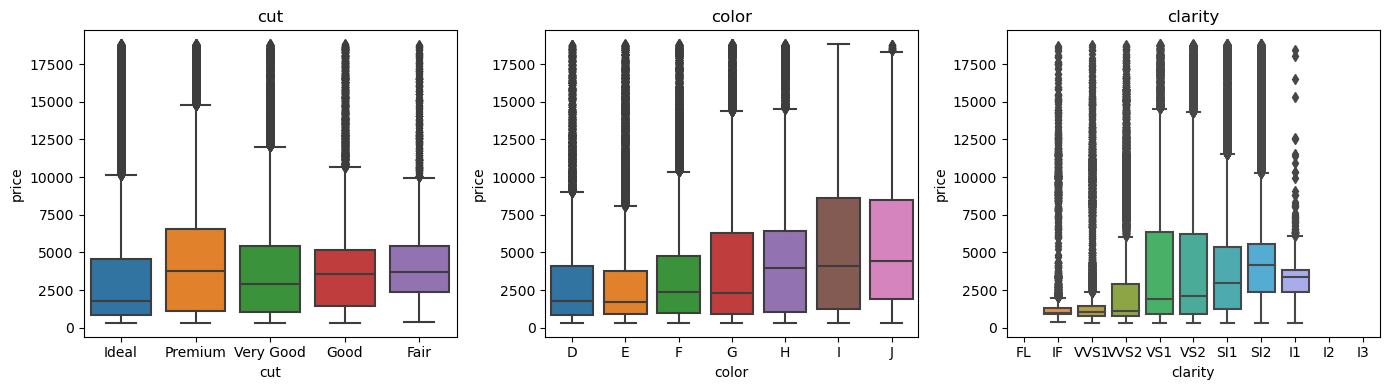

In [8]:
categorical_columns = all_data.select_dtypes(include="object").columns
fig, axes = plt.subplots(ncols=3, figsize=(14, 4), squeeze=True)


orders = {
    "cut": ["Ideal", "Premium", "Very Good", "Good", "Fair"],
    "color": ["D", "E", "F", "G", "H", "I", "J"],
    "clarity": ["FL", "IF", "VVS1", "VVS2", "VS1", "VS2", "SI1", "SI2", "I1", "I2", "I3"],
}


for col_name, ax in zip(categorical_columns, axes):
    sns.boxplot(y=y, x=train_data[col_name], ax=ax, order=orders[col_name])
    ax.set_title(col_name)
    ax.set_axis_on()

plt.tight_layout()
plt.show()

It's interesting that worse cuts, colors and clarities present a tendency of higher prices. This is completely unintuitive. Likely, this is explained by the interaction with other variables. For instance, good clarity gemstones may be smaller on average, driving the price down.

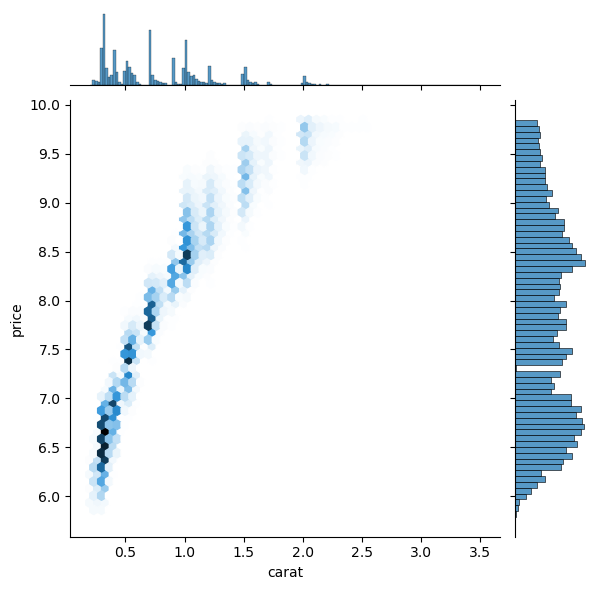

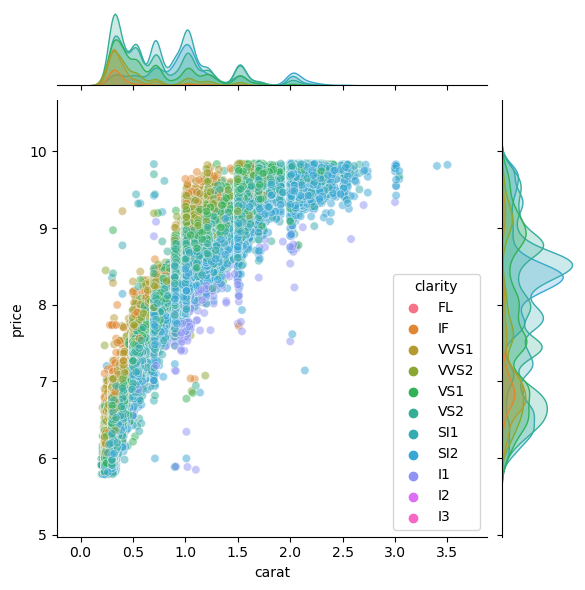

In [9]:
ax = sns.jointplot(x=train_data["carat"], y=y_log, kind="hex")
plt.show()
ax = sns.jointplot(x=train_data["carat"], y=y_log, hue=train_data["clarity"], hue_order=orders["clarity"], alpha=0.5)

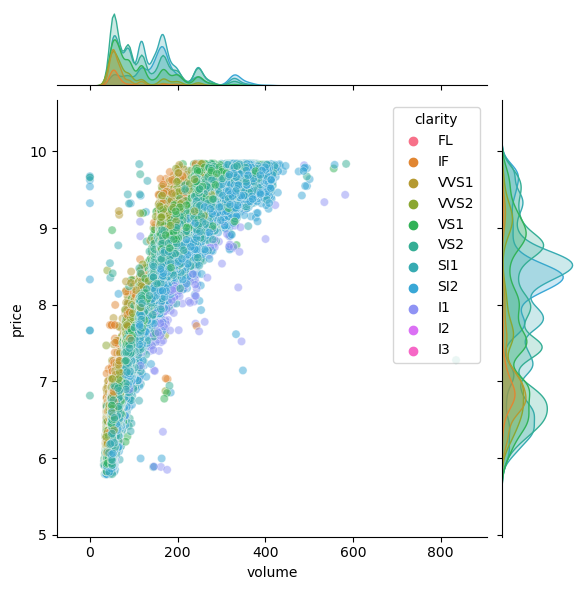

In [10]:
all_data["volume"] = all_data["x"] * all_data["y"] * all_data["z"]
all_data["volume"].round(2)

ax = sns.jointplot(x=all_data.iloc[:n_train]["volume"], y=y_log, hue=all_data.iloc[:n_train]["clarity"], hue_order=orders["clarity"], alpha=0.5)

For the same volume or carat, we can see that there's a tendency that gemstones with worse clarities have lower prices.

Let's encode ordinal variables and add new variables based on the existing ones. Check XXX for more details about the new variables.

In [11]:
# https://www.kaggle.com/competitions/playground-series-s3e8/discussion/389207

orders_dict = {
    k: {vv: i for i, vv in enumerate(v)}
    for k, v in orders.items()
}

all_data['cut'] = all_data['cut'].apply(lambda x: orders_dict["cut"][x])
all_data['color'] = all_data['color'].apply(lambda x:orders_dict["color"][x])
all_data['clarity'] = all_data['clarity'].apply(lambda x:orders_dict["clarity"][x])
all_data["volume"] = all_data["x"] * all_data["y"] * all_data["z"]
all_data["surface_area"] = 2 * (all_data["x"] * all_data["y"] + all_data["y"] * all_data["z"] + all_data["z"] * all_data["x"])
# all_data["aspect_ratio_xy"] = all_data["x"] / all_data["y"]
# all_data["aspect_ratio_yz"] = all_data["y"] / all_data["z"]
# all_data["aspect_ratio_zx"] = all_data["z"] / all_data["x"]
all_data["diagonal_distance"] = np.sqrt(all_data["x"] ** 2 + all_data["y"] ** 2 + all_data["z"] ** 2)
all_data["relative_height"] = (all_data["z"] - all_data["z"].min()) / (all_data["z"].max() - all_data["z"].min())
all_data["relative_position"] = (all_data["x"] + all_data["y"] + all_data["z"]) / (all_data["x"] + all_data["y"] + all_data["z"]).sum()
all_data["volume_ratio"] = all_data["x"] * all_data["y"] * all_data["z"] / (all_data["x"].mean() * all_data["y"].mean() * all_data["z"].mean())
all_data["length_ratio"] = all_data["x"] / all_data["x"].mean()
all_data["width_ratio"] = all_data["y"] / all_data["y"].mean()
all_data["height_ratio"] = all_data["z"] / all_data["z"].mean()
all_data["sphericity"] = 1.4641 * (6 * all_data["volume"])**(2/3) / (1e-4 + all_data["surface_area"])
# all_data["compactness"] = all_data["volume"]**(1/3) / all_data["x"]

In [12]:
import warnings

import xgboost as xgb
import lightgbm as lgbm
import catboost as cb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


def train_cv_regressor(model_class, X, y, model_params, folds: int = 5, seed: int = 324):
    kf = KFold(n_splits=folds, random_state=seed, shuffle=True)
    models = []
    errors = []
    for i, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = model_class(**model_params, random_state=seed)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        val_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        errors.append(rmse)
        print(f"Fold {i + 1}: RMSE = {rmse:.3f}")
        models.append(model)
    mean_rmse = np.average(errors)
    print(f"Average RMSE: {mean_rmse:.3f}")
    return models


def train_regressor(model_class, X_train, X_val, y_train, y_val, model_params, seed: int = 324):
    model = model_class(**model_params, random_state=seed)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    val_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    print(f"RMSE = {rmse:.3f}")
    return model

In [13]:
xgb_params = {
    "n_estimators": 8_000,
    "learning_rate": 0.05,
    "max_depth": 8,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "reg:squarederror",
    "early_stopping_rounds": 300,
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
}


lgbm_params = {
    "n_estimators": 4_000,
    "learning_rate": 0.02,
    "num_iterations": 1000,
    "max_depth": 8,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "regression",
}


cb_params = {
    "n_estimators": 2_500,
    "learning_rate": 0.05,
    "max_depth": 8,
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
}


X = all_data.iloc[:n_train]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print("XGBoost")
    _ = train_cv_regressor(xgb.XGBRegressor, X, y, xgb_params)
    print("------------")
    print("LightGBM")
    _ = train_cv_regressor(lgbm.LGBMRegressor, X, y, lgbm_params)
    print("------------")
    print("Catboost")
    _ = train_cv_regressor(cb.CatBoostRegressor, X, y, cb_params)

XGBoost
Fold 1: RMSE = 562.627
Fold 2: RMSE = 573.603
Fold 3: RMSE = 593.286
Fold 4: RMSE = 569.094
Fold 5: RMSE = 579.472
Average RMSE: 575.616
------------
LightGBM
Fold 1: RMSE = 564.897
Fold 2: RMSE = 573.921
Fold 3: RMSE = 595.198
Fold 4: RMSE = 568.686
Fold 5: RMSE = 578.902
Average RMSE: 576.321
------------
Catboost
Fold 1: RMSE = 565.782
Fold 2: RMSE = 572.259
Fold 3: RMSE = 592.199
Fold 4: RMSE = 566.891
Fold 5: RMSE = 578.673
Average RMSE: 575.161


In [14]:
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone


class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds: int = 5, random_state: int = 342):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        self.random_state = random_state

    # We again fit the data on clones of the original models
    def fit(self, X, y):
        X = X.values
        y = y.values
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)

        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(
                    X[train_index],
                    y[train_index],
                    eval_set=[(X[holdout_index], y[holdout_index])],
                    verbose=False,
                )
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    # Do the predictions of all base models on the test data and use the averaged predictions as
    # meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack(
            [
                np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
                for base_models in self.base_models_
            ]
        )
        return self.meta_model_.predict(meta_features)

In [15]:
from sklearn.linear_model import LinearRegression


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=342)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print("XGBoost")
    xgb_model = train_regressor(xgb.XGBRegressor, X_train, X_val, y_train, y_val, xgb_params)
    print("LighGBM")
    lgbm_model = train_regressor(lgbm.LGBMRegressor, X_train, X_val, y_train, y_val, lgbm_params)
    print("Catboost")
    cb_model = train_regressor(cb.CatBoostRegressor, X_train, X_val, y_train, y_val, cb_params)

    meta_model = LinearRegression()
    stacking_models = StackingAveragedModels([xgb_model, lgbm_model, cb_model], meta_model=meta_model)
    stacking_models.fit(X_train, y_train)

val_pred = stacking_models.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, val_pred))
print(f"Ensemble RMSE = {rmse:.3f}")

XGBoost
RMSE = 577.983
LighGBM
RMSE = 578.540
Catboost
RMSE = 576.964
Ensemble RMSE = 574.254


In [16]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    stacking_models = StackingAveragedModels([xgb_model, lgbm_model, cb_model], meta_model=meta_model)
    stacking_models = stacking_models.fit(X, y)

In [17]:
test_data = all_data.iloc[n_train:]

pred = stacking_models.predict(test_data)
submission = pd.DataFrame({"id": test_data["id"], "price": pred})
submission.to_csv("./data/submission.csv", index=False)